In [1]:
# Some tests of NuSTAR FoV map in comparison to other X-ray data
# 
# 11-Apr-2023    IGH
# 12-Apr-2023    Fixed nustar_pysolar maps to work with older evt converted files
# 17-Apr-2023    Add in label per NuSTAR detector quadrant
#               Added in more events
# 21-Apr-2023   Added in AIA HEK flares
# 30-Jan-2024   Reran for Dec 2023 data
# 15-May-2024   Reran for Mar 2024 data
# 12-Jul-2024   Reran in Jun 2024 data

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy import timeseries as ts
from sunpy.time import parse_time
from sunpy.coordinates import frames, get_horizons_coord
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import datetime
import pandas as pd
import os
from pathlib import Path
import glob
from stixdcpy.quicklook import LightCurves

import nustar_pysolar as nustar
from scipy import ndimage

import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from sunpy.coordinates import Helioprojective

import nsx_func

import warnings
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 20,'font.family':"sans-serif",\
            'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [3]:
# List of all the NuSTAR observations, with my naming, 
# based off first day of observing per campaign
dobs=['20140910','20141101','20141211',
    '20150429','20150901',
    '20160219','20160422','20160726',
    '20170321','20170821','20170911','20171010',
    '20180529','20180907','20180928',
    '20190112','20190412','20190425','20190702',
    '20200129','20200221','20200606','20200912',
    '20210108','20210429','20210720','20210730','20211117',
    '20220224','20220603','20220906','20221209',
    '20230318','20231228',
    '20240330','20240630']

# Data directory
# ddir=str(Path.home())+'/data/heasarc_nustar/'
ddir='/Volumes/Samsung_T5/data/heasarc_nustar/'

In [4]:
# # Find all pointings/IDs for the chosen observation 
# for icamp in [21,23,24,25,26,27,28,29,30,31,32]:
# # for icamp in [29]:

#     maindir=ddir+'ns_'+dobs[icamp]+'/'
#     print(icamp, ' --- ',maindir)
#     # Most start with 20 or 80 or 90?
#     ids = [f.name for f in os.scandir(maindir) \
#         if (f.is_dir() and (f.name.startswith('20') or f.name.startswith('80') or f.name.startswith('90')))]
#     ids=sorted(ids)

#     # Filter out random other dirs
#     ids=[f for f in ids if not f.endswith('_new')]

#     # Remove the mosiac from 20220603
#     if (dobs[icamp] == '20220603'):
#         ids=[f for f in ids if f.startswith('2062400')]
        
#     print("#: ",len(ids),' --- ',ids)

35  ---  /Volumes/Samsung_T5/data/heasarc_nustar/ns_20240630/
#:  3  ---  ['21011015001', '21011016001', '21011017001']
21011015001
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


RemoteDisconnected: Remote end closed connection without response

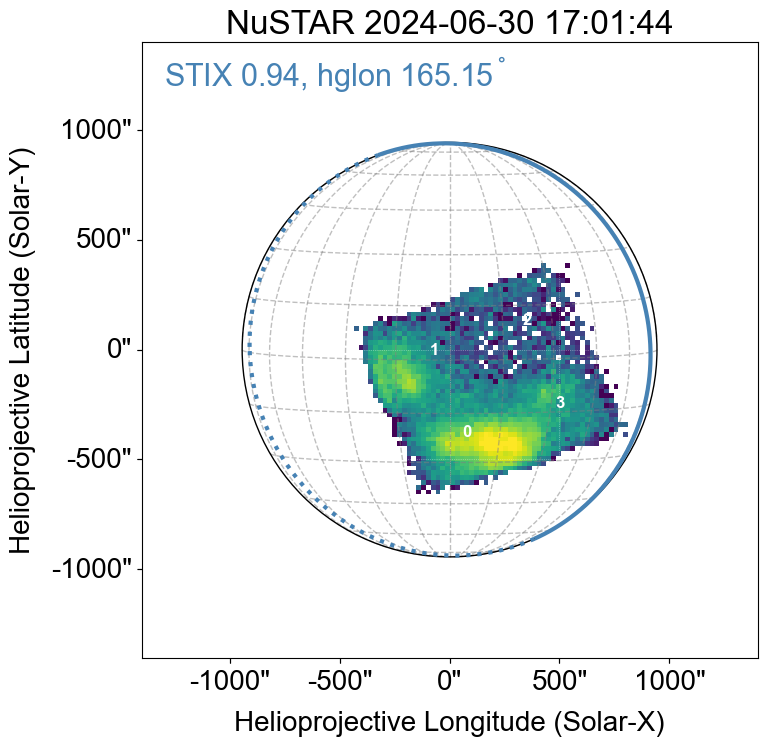

In [5]:
# Plot NuSTAR resampled map for pointing with GOES flare locations
# And add in the solar orbiter limb/FoV/HG longitude angle
# for icamp in [21,23,24,25,26,27,28,29,30,31,32,33,34]:
for icamp in [35]:
    maindir=ddir+'ns_'+dobs[icamp]+'/'
    print(icamp, ' --- ',maindir)
    # Most start with 20 or 80 or 90?
    ids = [f.name for f in os.scandir(maindir) \
        if (f.is_dir() and (f.name.startswith('20') or f.name.startswith('21') or f.name.startswith('80') or f.name.startswith('90')))]
    ids=sorted(ids)
    # Filter out random other dirs
    ids=[f for f in ids if not f.endswith('_new')]
    # Remove the mosiac from 20220603
    if (dobs[icamp] == '20220603'):
        ids=[f for f in ids if f.startswith('2062400')]
    # Remove pointings with no evt data
    if (dobs[icamp] == '20240330'):
        ids.remove('20801046001') 
        ids.remove('20801047001')      
    print("#: ",len(ids),' --- ',ids)

    # Do the map for each pointing
    for nsid in ids:
        print(nsid)

        hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
        evtdata=hdulist[1].data
        hdr = hdulist[1].header
        hdulist.close()

        cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
        nn = nustar.map.make_sunpy(cevt0, hdr,norm_map=True,ssw_legacy=True)

        xylim=1400
        bl=np.array([-1*xylim,-xylim])
        tr=np.array([xylim,xylim])
        bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nn.coordinate_frame)
        top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nn.coordinate_frame)
        snm = nn.submap(bottom_left, top_right=top_right)
        snmr=snm.resample([128, 128] * u.pixel)

        solo_coord = get_horizons_coord("solo", snmr.date)
        ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                            frame=frames.Helioprojective(observer=solo_coord, obstime=snmr.date))
        solo_header = sunpy.map.make_fitswcs_header(np.full((10, 10), np.nan),ref_coord)
        solo_map = sunpy.map.Map(np.full((10, 10), np.nan), solo_header)

        dsolo=solo_map.meta['dsun_obs']
        hglnsolo=solo_map.meta['hgln_obs']
        dns=snmr.meta['dsun_obs']

        # Get the rounded down start-time for the filenaming to 
        # match the ltc approach (so not start-time of the map)
        tstart=snmr.date
        tend=tstart+nn.meta["ontime"]*u.s
        mint=tstart.datetime
        mint-=datetime.timedelta(minutes=5,seconds=mint.second)
        mint-=datetime.timedelta(minutes=mint.minute % 5)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(projection=snmr)
        snmr.plot(norm=colors.LogNorm(vmin=1e-2,vmax=1e1),cmap='viridis',axes=ax)
        snmr.draw_limb(axes=ax, color="k",lw=1)
        snmr.draw_grid(axes=ax, color="grey",lw=1,ls='--')

        # Label per det quadrant
        for det in range(4):
            ctemp = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0,dets_id=[det])
            nntemp = nustar.map.make_sunpy(ctemp, hdr,norm_map=True,ssw_legacy=True)
            bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nntemp.coordinate_frame)
            top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nntemp.coordinate_frame)
            snmtemp = nntemp.submap(bottom_left, top_right=top_right)
            pw,cx,cy=nsx_func.nsmapcen(snmtemp)
            ax.text((pw.Tx).to('deg').value,(pw.Ty).to('deg').value,f'{det}', \
                transform=ax.get_transform('world'),color='white',fontsize=12,fontweight='bold')

        # solo_map.draw_limb(color='steelblue',lw=3)
        visible, hidden = solo_map.draw_limb(axes=ax,color='steelblue',lw=3)
        # hidden.remove() 
        ax.text((-1300*u.arcsec).to('deg').value,(1200*u.arcsec).to('deg').value,
                    f'STIX {dsolo/dns:1.2f}, hglon {hglnsolo:.2f}$^\circ$',
                    transform=ax.get_transform('world'),color='steelblue',fontsize=22)

        # Anything in the GOES flare list? Obviously needs the internet to work
        trange=a.Time(tstart,tend)
        gsflin = Fido.search(trange,a.hek.EventType("FL"),a.hek.FRM.Name == "SSW Latest Events")
        gsflhk=gsflin["hek"]
        # # If HEK/LMSAL not responding can just not use Fido till working again 
        # gsflhk=''
        for gg in gsflhk:
            fl_xy = SkyCoord(gg['hpc_x']*u.arcsec, gg['hpc_y']*u.arcsec, 
                            frame=snmr.coordinate_frame)
            ax.plot_coord(fl_xy, '+',color='firebrick',mew=2,ms=42)
            ax.text(((42+gg['hpc_x'])*u.arcsec).to('deg').value,
                    ((42+gg['hpc_y'])*u.arcsec).to('deg').value,
                    gg["fl_goescls"]+'('+gg['event_peaktime'].isot[11:16]+')',
                    transform=ax.get_transform('world'),color='firebrick',fontsize=16)
        # Anything from AIA?
        aiaflin = Fido.search(trange,a.hek.EventType("FL"),a.hek.FRM.Name =="Flare Detective - Trigger Module")
        aiaflhk=aiaflin["hek"] 
        # # If HEK/LMSAL not responding can just not use Fido till working again 
        # aiaflhk=''
        for aa in aiaflhk:
            #  Only plot it if peak time during NuSTAR time window
            if (aa["event_peaktime"] >= tstart) and (aa["event_peaktime"] <= tend):
                fl_xy = SkyCoord(aa['hpc_x']*u.arcsec, aa['hpc_y']*u.arcsec, 
                                frame=snmr.coordinate_frame)
                ax.plot_coord(fl_xy, 'x',color='darkorchid',mew=2,ms=21)
                ax.text(((42+aa['hpc_x'])*u.arcsec).to('deg').value,
                        ((42+aa['hpc_y'])*u.arcsec).to('deg').value,
                        'AF('+aa['event_peaktime'].isot[11:16]+')',
                        transform=ax.get_transform('world'),color='darkorchid',fontsize=16) 
        ax.grid(False)
        ax.set_xlabel('HPC x [arcsec]')
        ax.set_ylabel('HPC y [arcsec]')
        ax.set_title(tstart.iso[0:19]+' to '+tend.iso[11:19])
        plt.colorbar(fraction=0.035, pad=0.03,label='NuSTAR A 2-10 keV [count $s^{-1}$]')
        plt.annotate(nsid,(0.03,0.03),xycoords='figure fraction',fontsize=20)
        fig.subplots_adjust(bottom=0.1, top=0.95, left=0.2, right=0.8)
        plt.savefig('figs/ns_'+dobs[icamp]+f'/map_{mint:%Y%m%d_%H%M}_'+nsid+'_ngs.png')
        plt.close()
